## Interpretation of the model

In [32]:
from tsfm import *
import os
import torch as t
import re
import matplotlib.pyplot as plt
import circuitsvis as cv
from IPython.display import display

## Model Evaluations

In [33]:
## Loading model architecture by the file name
def parse_filename(filename, get_loss_data=False):
    pattern = r"^weights_lyr(\d+)_head(\d+)dh(\d+)_dm(\d+)_nsample(\d+)\.pth$"
    match = re.match(pattern, filename)
    if match:
        n_layers = int(match.group(1))
        n_heads = int(match.group(2))
        d_head = int(match.group(3))
        d_model = int(match.group(4))
        n_samples = int(match.group(5))
        
        arch_dict = {
            "n_layers": n_layers,
            "n_heads": n_heads,
            "d_head": d_head,
            "d_model": d_model,
            "n_samples": n_samples
        }
        
        if get_loss_data:
            # consider the corresponding file in loss
            loss_filename = filename.replace("weights", "losses")
            loss_dir = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toylosses"
            loss_data = t.load(os.path.join(loss_dir, loss_filename))
            
            return arch_dict | loss_data
        
        return arch_dict
            
    
    raise ValueError("Invalid filename format")

def load_model(filename, device='cpu'):
    # get architecture from filename
    arch_params = parse_filename(filename)
    
    weights_dir = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toyweights"
    
    data_dict = t.load(os.path.join(weights_dir, filename), map_location=device)
    
    model = model_init(
        n_layers=arch_params["n_layers"],
        d_model=arch_params["d_model"],
        n_ctx=66,
        d_vocab=2,
        n_heads=arch_params["n_heads"],
        d_head=arch_params["d_head"],
        d_mlp=4 * arch_params["d_model"],
        device=device,
    )
    model.load_state_dict(data_dict)
    
    return model

def batch_load_model(directory, device='cpu'):
    weights_dir = directory
    filenames = os.listdir(weights_dir)
    models = {}
    for filename in filenames:
        model = load_model(filename, device=device)
        arch_params = parse_filename(filename)
        
        models[(arch_params["n_layers"], arch_params["d_model"], arch_params["n_heads"])] = model
        
    return models


C:\Users\15896\AppData\Local\Temp\ipykernel_266704\2554423986.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_data = t.load(os.path.join(loss_dir, loss_filename))


Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


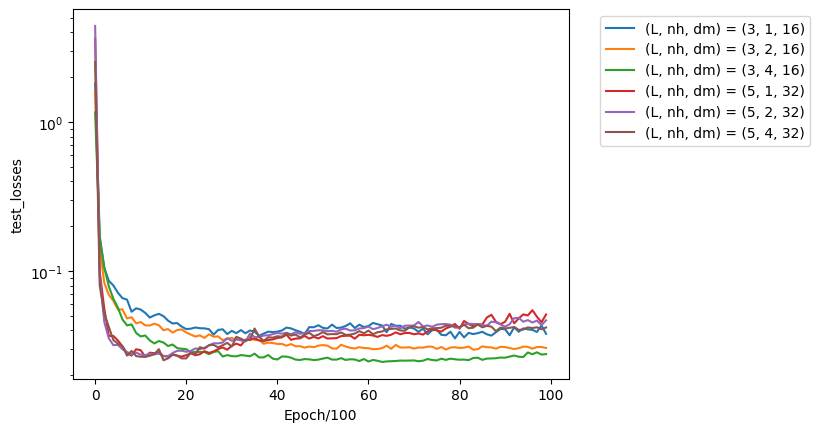

In [34]:
# Analyzing the losses of the model and pick the best one for interp

import os
weights_dir = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toyweights"
losses_dir = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toylosses"

weights_files = os.listdir(weights_dir)

dats = []
loss_key = 'test_losses'
for filename in weights_files:
    dat = parse_filename(filename, get_loss_data=True)
    dats.append(dat)
    if dat["n_samples"] == 5000:
        plt.plot(dat[loss_key], label=f"(L, nh, dm) = ({dat['n_layers']}, {dat['n_heads']}, {dat['d_model']})")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch/100")
plt.ylabel(f"{loss_key}")
plt.yscale("log")

batch_models = batch_load_model(weights_dir)



In [35]:
import interp

filenames = os.listdir(weights_dir)
models = {}
for filename in filenames:
    if "nsample5000" in filename:
        model = load_model(filename)
        arch_params = parse_filename(filename)
    
        models[(arch_params["n_layers"], arch_params["d_model"], arch_params["n_heads"])] = model


Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


C:\Users\15896\AppData\Local\Temp\ipykernel_266704\2554423986.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = t.load(os.path.join(weights_dir, filename), ma

In [39]:
# (hand-)pick the best-performing model (3, 1, 12) and (3, 3, 12)

models = []
for filenames in weights_files:
    if "lyr3_head3dh4_dm12" in filenames:
        models.append(load_model(filenames))
    if "lyr3_head1dh12_dm12" in filenames:
        models.append(load_model(filenames))
        
# generate test data and assert they are low-loss
train_data, train_w, test_data, test_w, train_t, test_t = generate_springdata(
    num_samples=10000,
    sequence_length=64,
    device='cpu'
)

Moving model to device:  cpu
Moving model to device:  cpu


C:\Users\15896\AppData\Local\Temp\ipykernel_266704\2554423986.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = t.load(os.path.join(weights_dir, filename), ma

In [40]:
import torch.nn.functional as F
for model in models.values():
    model.eval()
    in_dist_prediction = model(train_data)
    loss = F.mse_loss(in_dist_prediction[:, :-1, :], train_data[:, 1:, :])
    ood_prediction = model(test_data)
    ood_loss = F.mse_loss(ood_prediction[:, :-1, :], test_data[:, 1:, :])
    
    print(f"Train Loss: {loss.item()}")
    print(f"Test Loss: {ood_loss.item()}")


AttributeError: 'list' object has no attribute 'values'

## Attention patterns

Construct Linear networks going from hidden-layer activations in the datastream to the desired quantity

In [38]:
for model in models.values():
    print(model.cfg.d_head, model.cfg.d_model, model.cfg.n_layers)

AttributeError: 'list' object has no attribute 'values'

In [41]:
samples = t.cat([train_data, test_data], dim=0)
omegas = t.cat([train_w, test_w], dim=0)
times = t.cat([train_t, test_t], dim=0)

# randomly shuffle
idx = t.randperm(samples.size(0))
samples = samples[idx]
omegas = omegas[idx]
times = times[idx]


In [42]:
model0 = models[(3, 16, 2)]
model0.eval()

rd_ind = t.randint(0, 15000, (1,)).item()
# rd_ind = 7542
sample = samples[rd_ind, :, :].unsqueeze(0)

preds0, cache0 = model0.run_with_cache(sample)

print(f"Visualizing Pattern {rd_ind}")
sampled_w = omegas[rd_ind].item()
sampled_dt = times[rd_ind, 1].item()
print(f"w={sampled_w:.3g}, dt={sampled_dt:.3g}, one-step phase {sampled_w * sampled_dt/(2 * math.pi):.3g}*2pi")

for lyr in range(3):
    attn_pattern = cache0["pattern", lyr].squeeze(0)
    display(
    cv.attention.attention_patterns(
        tokens=[str(i) for i in range(attn_pattern.shape[1])],
        attention=attn_pattern,
    )
)

TypeError: list indices must be integers or slices, not tuple

Notes: These patterns show periodic attention paid by any particular position to others - This implies that the attention heads have the capacity of recording period informations.

On the other hand, the attention head (1) seems to be a simple exponential decay (In the cases of three attention heads per layer)

## Linear module for hidden layers

In [78]:
# get the desired quantity which we want to compute the correlation/causal relationship with.
# using models[1]

n_layers = model.cfg.n_layers
n_head = model.cfg.n_heads
d_model = model.cfg.d_model
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab
n_ctx = model.cfg.n_ctx

pred, cache = model.run_with_cache(samples)

First we retrieve the residual stream at all stages in the cache:

- `pre`: before the attention heads
- `mid`: after attention heads, before the MLP
- `post`: after the MLP

Since we are not doing layernorms (which is supposed to be bad for interpretability), the $i^\mathrm{th}$ layer's `post` should be the same as the $(i+1)^\mathrm{th}$ layers' `pre`.

In [79]:
# Getting the available keys in the cache
# print("\n".join(cache.keys()))

# pre = 0, mid = 1, post = 2 along dimension 0
# layer along dimension 1
# shape of resid_stream = (3, n_layers, n_samples, n_ctx, d_model)

def get_str_stage(i: int):
    if i == 0:
        return "pre"
    elif i == 1:
        return "mid"
    elif i == 2:
        return "post"
    else:
        raise ValueError("Invalid stage")

n_samples = 15000 # from data stream
resid_stream = t.zeros((3, n_layers, n_samples, n_ctx-1, d_model))

for lyr in range(n_layers):
    for stage in range(3):
        idx_str = f"blocks.{lyr}.hook_resid_{get_str_stage(stage)}"
        resid_stream[stage, lyr, :, :, :] = cache[idx_str]


In [80]:
# Linear interpolation of data with sklearn
# mapping from the model prediction to the hidden states

from generate_probe_targets import *
import einops

input = resid_stream[2, 2, :, :, :] # shape = (n_samples, n_ctx, d_model) = (15000, 65, 12)


def generate_targets(
    samples: Float[Tensor, "n_sample n_ctx d_model"],
    omegas: Float[Tensor, "n_sample"],
    times: Float,
    order=1,
    # TODO: Include the damping factor as well
):
    # get left and right samples, for lead/lag in-context predictions
    samples_left = samples[:, :-1, :]
    samples_right = samples[:, 1:, :]
    
    # canonical correlation analysis
    # encode the matrices
    A = t.zeros((samples_left.shape[0], samples_right.shape[1], 2, 2))
    rep_omega = einops.repeat(omegas, "n_sample -> n_sample n_ctx", n_ctx=samples_left.shape[1])
    rep_dt = times[:, 1].unsqueeze(1).repeat(1, samples_left.shape[1])
    
    # print(A.shape, omegas.shape)
    A[:, :, 0, 0] = 0.0
    A[:, :, 0, 1] = rep_dt
    A[:, :, 1, 0] = - rep_omega ** 2 * rep_dt
    A[:, :, 1, 1] = 0.0 # For zero damping
    
    # get targets by directly flattening the last two dimensions
    # NOTE: We are trying to map the hidden states to the target intermediate, which is itself an *operator*...
    
    A_propagate_dt = t.matrix_power(A, order)
    target = einops.rearrange(A_propagate_dt, "n_sample n_ctx i j -> n_sample n_ctx (i j)")
    
    return target

target = generate_targets(samples, omegas, times, order=1)

def generate_matexp_targets(
    samples: Float[Tensor, "n_sample n_ctx d_model"],
    omegas: Float[Tensor, "n_sample"],
    times: Float,
):
    A = t.zeros((samples.shape[0], samples.shape[1]-1, 2, 2))
    rep_omega = einops.repeat(omegas, "n_sample -> n_sample n_ctx", n_ctx=samples.shape[1]-1)
    rep_dt = times[:, 1].unsqueeze(1).repeat(1, samples.shape[1]-1)
    
    rep_phase = rep_omega * rep_dt
    A[:, :, 0, 0] = t.cos(rep_phase)
    A[:, :, 0, 1] = t.sin(rep_phase) / rep_omega
    A[:, :, 1, 0] = - rep_omega * t.sin(rep_phase)
    A[:, :, 1, 1] = t.cos(rep_phase)
    
    target = einops.rearrange(A, "n_sample n_ctx i j -> n_sample n_ctx (i j)")
    
    return target

target_matexp = generate_matexp_targets(samples, omegas, times)

In [32]:
# Sanity checks
print("target shape:", target_matexp.shape) # (n_samples, n_ctx, 4=2x2)
print("samples shape:", samples.shape) # (n_samples, n_ctx, d_vocab)
print("input shape:", input.shape) # (n_samples, n_ctx, d_model)


target shape: torch.Size([15000, 64, 4])
samples shape: torch.Size([15000, 65, 2])
input shape: torch.Size([15000, 65, 12])


In [ ]:
## Wrapping up to a function
from sklearn.linear_model import Ridge

def lin_reg(
    input: Float[Tensor, "n_sample n_ctx d_model"],
    target: Float[Tensor, "n_sample n_ctx targ"],
    reverse=False,  # if true, use linreg against target -> input (hidden layer states)
    trunc=None, # or int: number of samples the regression is performed on
    seed=None,
):
    if seed is not None:
        t.manual_seed(seed)
        np.random.seed(seed)
    
    np_input = input[:, 1:, :].detach().cpu().numpy()
    np_target = target.detach().cpu().numpy()
    
    if trunc is not None:
        id_row = np.random.choice(np_input.shape[0], trunc, replace=False)
        np_input = np_input[id_row]
        np_target = np_target[id_row]
    
    # reshape
    np_input = einops.rearrange(np_input, "n_sample n_ctx d_model -> (n_sample n_ctx) d_model")
    np_target = einops.rearrange(np_target, "n_sample n_ctx targ -> (n_sample n_ctx) targ")
    
    clf = Ridge(alpha=1.0)
    if not reverse:
        clf.fit(np_input, np_target)
        r2 = clf.score(np_input, np_target)
        mse = np.mean((clf.predict(np_input) - np_target) ** 2)
    else:
        clf.fit(np_target, np_input)
        r2 = clf.score(np_target, np_input)
        mse = np.mean((clf.predict(np_target) - np_input) ** 2)
    
    return r2, mse
    


In [54]:
r2, mse = lin_reg(input, target_matexp, reverse=False, seed=42)
print(f"R2: {r2}, MSE: {mse}")

R2: 0.6819650530815125, MSE: 0.2871266305446625


### Matrix Exponential correlations across different models

In [ ]:
batch_model = batch_load_model(weights_dir)
model = batch_model[(3, 12, 1)] # (layers, d_model, heads)
pred, cache = model.run_with_cache(samples)

In [126]:
pos_str = cache.keys()
print(pos_str)


dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.attn.hook_q', 'blocks.2.attn.hook_k', 'blocks.2.attn.hook_v', 'blocks.2.attn.hook_attn_scores', 'blocks.2.attn.hook_pattern', 'blocks.2.attn.hook_z', 'blocks.2.hook_attn_out', 'blocks.2.hook_resid_mid', 'blocks.2.mlp.hook_pre', 'blo

In [132]:

def get_annotations(cache):
    hook_str = cache.keys()
    annotation_table = {}
    
    for hook in hook_str:
        layer = re.findall(r'\d+', hook)
        if layer != []:
            layer = layer[0]
        
        if "mlp" in hook:
            if "post" in hook:
                annotation_table[hook] = "post-mlp" + layer
            elif "pre" in hook:
                annotation_table[hook] = "pre-mlp" + layer
        else:
            if "resid" in hook:
                if "post" in hook:
                    annotation_table[hook] = "resid-post" + layer
                elif "pre" in hook:
                    annotation_table[hook] = "resid-pre" + layer
                elif "mid" in hook:
                    annotation_table[hook] = "resid-mid" + layer

    annotation_table = {v: k for k, v in annotation_table.items()}
    
    return annotation_table
                
get_annotations(cache)        



{'resid-pre0': 'blocks.0.hook_resid_pre',
 'resid-mid0': 'blocks.0.hook_resid_mid',
 'pre-mlp0': 'blocks.0.mlp.hook_pre',
 'post-mlp0': 'blocks.0.mlp.hook_post',
 'resid-post0': 'blocks.0.hook_resid_post',
 'resid-pre1': 'blocks.1.hook_resid_pre',
 'resid-mid1': 'blocks.1.hook_resid_mid',
 'pre-mlp1': 'blocks.1.mlp.hook_pre',
 'post-mlp1': 'blocks.1.mlp.hook_post',
 'resid-post1': 'blocks.1.hook_resid_post',
 'resid-pre2': 'blocks.2.hook_resid_pre',
 'resid-mid2': 'blocks.2.hook_resid_mid',
 'pre-mlp2': 'blocks.2.mlp.hook_pre',
 'post-mlp2': 'blocks.2.mlp.hook_post',
 'resid-post2': 'blocks.2.hook_resid_post'}

In [133]:
from typing import Dict, Tuple
import itertools
input = cache["post", 2]
target = generate_matexp_targets(samples, omegas, times)

r2, mse = lin_reg(input, target_matexp, reverse=True, trunc=3000)
print(f"R2: {r2}, MSE: {mse}")



def maxR2_models(model_list: Dict[Tuple[Int, Int, Int], HookedTransformer], target: Float[Tensor, "n_sample n_ctx targ"], reverse=False, trunc=1000):
    
    # For given model, calculate the maximum R2 score across all layers
    max_r2_dict = {}
    for model_key, model in model_list.items():
        pred, cache = model.run_with_cache(samples)
        max_r2 = 0
        max_r2_pos = None
        anno_tab = get_annotations(cache)
        
        for elem in anno_tab.keys():
            input = cache[elem]
            r2, mse = lin_reg(input, target, reverse=reverse, trunc=trunc)
            if r2 > max_r2:
                max_r2 = r2
                max_r2_pos = anno_tab[elem]
        
        max_r2_dict[model_key] = (max_r2, max_r2_pos)
    
    return max_r2_dict


def generate_heatmap(max_r2_dict: Dict[Tuple[Int, Int, Int], Tuple[Float, str]]):
    # The key inds: (layers, d_model, heads)
    # The value inds: (max_r2, position)
    # x-axis: layers
    # y-axis: d_model
    # color: r2 score
    # generate separate heatmaps for each head count
    
    # three plots, one for each head count
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    
    # get keys
    n_head = [key_tup[-1] for key_tup in max_r2_dict.keys()]
    n_layers = [key_tup[0] for key_tup in max_r2_dict.keys()]
    d_models = [key_tup[1] for key_tup in max_r2_dict.keys()]
    head_count = max(n_head)
    D_model = max(d_models)
    L = max(n_layers)
    
    for i in range(head_count):
        # get data matrix
        data_matrix = np.zeros((L, D_model), dtype=float)
        annotation_matrix = np.empty((L, D_model), dtype=str)
        for (row, col) in itertools.product(range(L), range(D_model)):
            data_matrix[row, col] = max_r2_dict[(row, col, i)][0]
            annotation_matrix[row, col] = max_r2_dict[(row, col, i)][1] + f"\n {data_matrix[row, col]:.3f}"
        
        # plot
        sns.heatmap(
            data_matrix,
            annot=annotation_matrix,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            ax=axes[i],
        )

    plt.show()

    
        
        
        
        
        

SyntaxError: expected ':' (1497506457.py, line 56)

## QK circuit weights

#### Implementing Fourier basis

In [41]:
# Also examine the activations of neurons

def make_fourier_basis(p: int) -> tuple[Tensor, list[str]]:
    """
    Returns a pair `fourier_basis, fourier_basis_names`, where `fourier_basis` is
    a `(p, p)` tensor whose rows are Fourier components and `fourier_basis_names`
    is a list of length `p` containing the names of the Fourier components (e.g.
    `["const", "cos 1", "sin 1", ...]`). You may assume that `p` is odd.
    """
    # Define a grid for the Fourier basis vecs (we'll normalize them all at the end)
    # Note, the first vector is just the constant wave
    fourier_basis = t.ones(p, p)
    fourier_basis_names = ["Const"]
    for i in range(1, p // 2 + 1):
        # Define each of the cos and sin terms
        fourier_basis[2 * i - 1] = t.cos(2 * t.pi * t.arange(p) * i / p)
        fourier_basis[2 * i] = t.sin(2 * t.pi * t.arange(p) * i / p)
        fourier_basis_names.extend([f"cos {i}", f"sin {i}"])
    # Normalize vectors, and return them
    fourier_basis /= fourier_basis.norm(dim=1, keepdim=True)
    return fourier_basis.to(device), fourier_basis_names

p = 65
fourier_basis, fourier_basis_names = make_fourier_basis(p)

def fourier_2d_basis_term(i: int, j: int) -> Float[Tensor, "p p"]:
    """
    Returns the 2D Fourier basis term corresponding to the outer product of the `i`-th component of the 1D Fourier
    basis in the `x` direction and the `j`-th component of the 1D Fourier basis in the `y` direction.

    Returns a 2D tensor of length `(p, p)`.
    """
    return fourier_basis[i][:, None] * fourier_basis[j][None, :]

def fft2d(tensor: Tensor) -> Tensor:
    """
    Retuns the components of `tensor` in the 2D Fourier basis.

    Asumes that the input has shape `(p, p, ...)`, where the
    last dimensions (if present) are the batch dims.
    Output has the same shape as the input.
    """
    # fourier_basis[i] is the i-th basis vector, which we want to multiply along
    return einops.einsum(tensor, fourier_basis, fourier_basis, "px py ..., i px, j py -> i j ...")

#### Get Fourier components for attention

In [61]:
# Analyze the attention weights for the model by following the QK circuit
from plotly_utils import imshow

lyr = 0
model = models[(3, 16, 2)]
W_QK = model.W_Q[lyr] @ model.W_K[lyr].transpose(1, 2)

pos_corr = model.W_pos @ W_QK @ model.W_pos.transpose(0, 1)
pos_corr = pos_corr[:, :-1, :-1].to(device)
# plot the results
for head in range(1):
    imshow(
        # fft2d(pos_corr[head])[:50, :50],
        pos_corr[head, :50, :50],
        labels={"x": "Key", "y": "Query"},
        width=400,
        height=300,
    )

# Do a 2D fourier transform around this
# No periodicity

In [50]:
neuron_acts_post = cache["post", 0]
neuron_acts_post.shape

NameError: name 'cache' is not defined

### Other direction

Note that there's abrupt change in attention weight patterns at layer 3. Specifically, the information got concentrated at the beginning. This is potentially due to something that has been done at the penultimate layer's MLP. An intuitive interpretation is that the transformer is somehow aware of the pattern from the start.

- Is it true that non-trivial changes occurs at layer 2?
- Is this fact correlated with an abrupt change with the encoding quality of the matrix exponential? If this is true then we would attribute layer 2 with higher importance as the "encoding step" for the matrix exponential.

**The questions**: Does the learning of Matrix exponential come from the attention layer or the MLP layer?

We obtain attention-only models that keeps the number of parameters roughly unchanged (moving some of the MLP params to the )

In [14]:
## Consider attention-only models
import tsfm
# Try to find whether this effect of concentration is due to the attention mechanism
# or the MLP

# list the number of params in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# shift to attention-only models

attn_only = True



model5_with_mlp = tsfm.model_init(
    n_layers=5,
    d_model=32,
    n_ctx=66,
    d_vocab=2,
    n_heads=1,
    d_head=32,
    d_mlp=128,
    device='cpu',
)

n_params = count_parameters(model5_with_mlp)
print(f"Number of parameters in model5_with_mlp: {n_params}")

model5_attn_only = tsfm.model_init(
    n_layers=5,
    d_model=32,
    n_ctx=66,
    d_vocab=2,
    n_heads=2,
    d_mlp=0,
    d_head=48,
    device='cpu',
    attn_only=True,
)

n_params = count_parameters(model5_attn_only)
print(f"Number of parameters in model5_attn_only): {n_params}")

model3_with_mlp = tsfm.model_init(
    n_layers=3,
    d_model=16,
    n_ctx=66,
    d_vocab=2,
    n_heads=1,
    d_head=32,
    d_mlp=64,
    device='cpu',
)

n_params = count_parameters(model3_with_mlp)
print(f"Number of parameters in model3_with_mlp: {n_params}")

mdoel3_attn_only = tsfm.model_init(
    n_layers=3,
    d_model=16,
    n_ctx=66,
    d_vocab=2,
    n_heads=1,
    d_mlp=0,
    d_head=64,
    device='cpu',
    attn_only=True,
)

n_params = count_parameters(mdoel3_attn_only)
print(f"Number of parameters in mdoel3_attn_only): {n_params}")



Moving model to device:  cpu
Number of parameters in model5_with_mlp: 65154
Moving model to device:  cpu
Number of parameters in model5_attn_only): 65314
Moving model to device:  cpu
Number of parameters in model3_with_mlp: 14002
Moving model to device:  cpu
Number of parameters in mdoel3_attn_only): 14050


## Ablation analysis

We would like to test the hypothesis that the trained model only attends to first few tokens (somehow a lazy strategy has been learnt). This would mean that

1. The model prediction will be faulty if we zero-out the first few tokens. However, it will remain plausible if we only zero-out later tokens.
2. The model prediction is not robust against noise. This is because the model does not pay attention to later tokens and extract average behaviour. Instead, the later-time information has been tactically ignored.

### Matrix exponential encodings

In [86]:
import interp as ip

dir_name = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toyweights"
models = batch_load_model(dir_name)

samples, omegas, times = ip.data_generator(5000, 64)
targets = ip.generate_matexp_targets(samples, omegas, times)
max_r2_dict = ip.maxR2_models(
    models, targets, samples, reverse=False, trunc=100, alpha=3.0
)


C:\Users\15896\AppData\Local\Temp\ipykernel_258500\2554423986.py:39: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


In [87]:
for key, value in max_r2_dict.items():
    print(f"{key}: {value}")

(1, 12, 1): (0.5192010402679443, 'post-mlp0')
(1, 6, 1): (0.4196901023387909, 'post-mlp0')
(1, 6, 2): (0.32425737380981445, 'post-mlp0')
(1, 12, 2): (0.4304400384426117, 'post-mlp0')
(1, 6, 3): (0.45599526166915894, 'post-mlp0')
(1, 12, 3): (0.49524563550949097, 'post-mlp0')
(2, 12, 1): (0.5857927799224854, 'post-mlp1')
(2, 6, 1): (0.6915518045425415, 'post-mlp1')
(2, 6, 2): (0.4311741292476654, 'post-mlp1')
(2, 12, 2): (0.7520697116851807, 'post-mlp1')
(2, 6, 3): (0.3948291540145874, 'post-mlp1')
(2, 12, 3): (0.8037214279174805, 'post-mlp1')
(3, 12, 1): (0.8275164365768433, 'post-mlp2')
(3, 16, 1): (0.860641598701477, 'post-mlp2')
(3, 6, 1): (0.7041078209877014, 'post-mlp2')
(3, 6, 2): (0.6414147019386292, 'post-mlp2')
(3, 12, 2): (0.8382171988487244, 'post-mlp2')
(3, 16, 2): (0.8873907923698425, 'post-mlp2')
(3, 6, 3): (0.5947932600975037, 'post-mlp2')
(3, 12, 3): (0.8446335196495056, 'post-mlp2')
(3, 16, 4): (0.8378131985664368, 'post-mlp2')
(5, 32, 1): (0.8890947103500366, 'post-ml

[[['', '', 'post-mlp0\n 0.519', 'post-mlp0\n 0.420'], ['', '', 'post-mlp1\n 0.586', 'post-mlp1\n 0.692'], ['post-mlp2\n 0.861', '', 'post-mlp2\n 0.828', 'post-mlp2\n 0.704'], ['', 'post-mlp4\n 0.889', '', '']], [['', '', 'post-mlp0\n 0.430', 'post-mlp0\n 0.324'], ['', '', 'post-mlp1\n 0.752', 'post-mlp1\n 0.431'], ['post-mlp2\n 0.887', '', 'post-mlp2\n 0.838', 'post-mlp2\n 0.641'], ['', 'post-mlp4\n 0.852', '', '']], [['', '', 'post-mlp0\n 0.495', 'post-mlp0\n 0.456'], ['', '', 'post-mlp1\n 0.804', 'post-mlp1\n 0.395'], ['', '', 'post-mlp2\n 0.845', 'post-mlp2\n 0.595'], ['', '', '', '']], [['', '', '', ''], ['', '', '', ''], ['post-mlp2\n 0.838', '', '', ''], ['', 'post-mlp4\n 0.889', '', '']]]


IndexError: index 3 is out of bounds for axis 0 with size 3

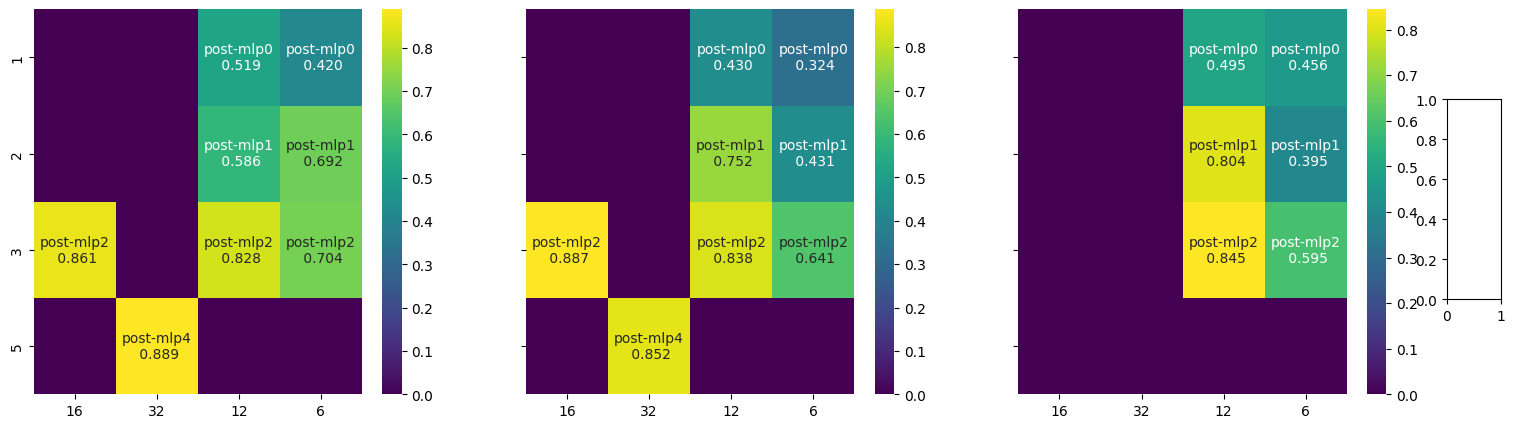

In [88]:
ip.generate_heatmap(max_r2_dict)


### Perturbation on generated data

In [89]:
samples.shape, omegas.shape, times.shape

(torch.Size([7500, 65, 2]), torch.Size([7500]), torch.Size([7500, 65]))

In [93]:
model = models[(3, 16, 2)]

pred, cache = model.run_with_cache(samples)

model.eval()

loss = F.mse_loss(pred[:, :-1, :], samples[:, 1:, :])
print(f"Loss: {loss.item()}")

# zero out the first few sampled data
window = 5
start = 0

sample_init_ablated = samples.clone()
sample_init_ablated[:, start:start+window, :] = 0.0

pred_ablated, cache_ablated = model.run_with_cache(sample_init_ablated)
loss_ablated = F.mse_loss(pred_ablated[:, :-1, :], samples[:, 1:, :])
print(f"Ablated Loss: {loss_ablated.item()}")

sample_late_ablated = samples.clone()
sample_late_ablated[:, -window:, :] = 0.0

pred_late_ablated, cache_late_ablated = model.run_with_cache(sample_late_ablated)
loss_late_ablated = F.mse_loss(pred_late_ablated[:, :-1, :], samples[:, 1:, :])
print(f"Late Ablated Loss: {loss_late_ablated.item()}")


Loss: 0.02369750291109085
Ablated Loss: 0.3806089460849762
Late Ablated Loss: 0.06993084400892258


In [5]:
import interp as ip

dir_name = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toyweights"
models = ip.batch_load_model(dir_name)
model = models[(3, 16, 2)]



Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


c:\Users\15896\myenv\Hydra\mech_interp_capstone\src\interp.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = t.load(os.path.join(weights_dir, filename), map_l

Text(0, 0.5, 'MSE Ablated Loss')

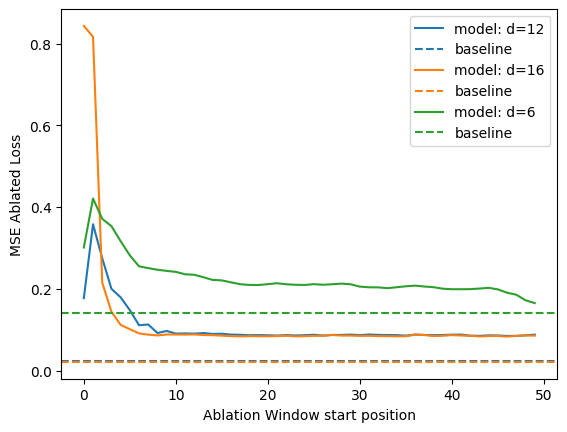

In [27]:
import matplotlib.pyplot as plt

samples, omegas, times = ip.data_generator(100, 64)
windows = [1, 3, 5, 10]
window = windows[2]
for model in models.values():
    # filter the model
    if model.cfg.n_heads == 1 and model.cfg.n_layers == 3:
        abl_losses, loss_baseline = ip.interp_with_ablation(model, window, samples)
        plt.plot(abl_losses.detach().numpy()[:50], label=f"model: d={model.cfg.d_model}")

        plt.axhline(loss_baseline.detach().numpy(), color=plt.gca().lines[-1].get_color(), linestyle='--', label="baseline")
plt.legend()
plt.xlabel("Ablation Window start position")
plt.ylabel("MSE Ablated Loss")


## Context windows

In [8]:
for model_key in models.keys():
    print(model_key)

(1, 12, 1)
(1, 6, 1)
(1, 6, 2)
(1, 12, 2)
(1, 6, 3)
(1, 12, 3)
(2, 12, 1)
(2, 6, 1)
(2, 6, 2)
(2, 12, 2)
(2, 6, 3)
(2, 12, 3)
(3, 12, 1)
(3, 16, 1)
(3, 6, 1)
(3, 6, 2)
(3, 12, 2)
(3, 16, 2)
(3, 6, 3)
(3, 12, 3)
(3, 16, 4)
(5, 32, 1)
(5, 32, 2)
(5, 32, 4)
